# Analytic Second Comparison Using LFW Dataset - VGGFace (RESNET50)

Several feature extractor:
1. Face Embedding: Facenet
2. Face Embedding: VGG Face
3. Face Embedding: VGG Face - VGG16
4. Face Embedding: VGG Face - RESNET50
5. LBPH (Local Binary Pattern Histogram)

In [1]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, f1_score
from keras import backend as K
from feature_extractor.face_feature_extractor import FaceFeatureExtractor
import numpy as np
import cv2 as cv
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


# Read Dataset

In [2]:
import os

In [3]:
DIR_PATH = '../lfw/'
image_path_list = []
labels = []
name_dictionary = {}
counter = 0
for root, dirs, files in os.walk(DIR_PATH):
    for filename in files:
        person_name = ' '.join(filename.split('.')[0].split('_')[0:-1]) 
        file_path = os.path.join(root, filename)
        if person_name not in name_dictionary:
            counter += 1
            name_dictionary[person_name] = counter
        image_path_list.append(file_path)
        labels.append(name_dictionary[person_name])

In [4]:
print(len(labels))
print(len(image_path_list))

13233
13233


In [5]:
image_path_list[0:5]

['../lfw/Ryan_Newman/Ryan_Newman_0001.jpg',
 '../lfw/Dimitar_Berbatov/Dimitar_Berbatov_0001.jpg',
 '../lfw/Ed_Rendell/Ed_Rendell_0001.jpg',
 '../lfw/Joe_Crede/Joe_Crede_0001.jpg',
 '../lfw/Norman_Mailer/Norman_Mailer_0001.jpg']

# Experiment

In [6]:
FACENET_MODEL_PATH = 'model_data/facenet/20180402-114759'
VGGFACE_MODEL_PATH = 'model_data/vgg_face_weights.h5'

In [7]:
mtcnn_detector = MTCNN()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
def predict(image_representation_list, true_label, test_representation, min_distance):
    minimum_label = None
    minimum_distance = min_distance
    
    for idx, image_representation in enumerate(image_representation_list):
        distance = euclidean(image_representation, test_representation)
        if distance < minimum_distance:
            minimum_distance = distance
            minimum_label = true_label[idx]
    
    return minimum_label

In [9]:
def compute_score(predictions, labels):
    count_same = 0
    for idx, prediction in enumerate(predictions):
        if labels[idx] == prediction:
            count_same += 1
        elif labels[idx] == -2: # failed to detect face (still measure as valid)
            count_same += 1
    return count_same / len(predictions)

In [10]:
def write_checkpoint(filename, prediction_results):
    f = open(filename, 'w')
    for prediction in prediction_results:
        f.write(str(prediction) + '\n')
    f.close()

## VGGFace RESNET50

Based on experiment VGGFace RESNET50 have distance below 100 for euclidean if two image are the same person

In [11]:
feature_extractor = FaceFeatureExtractor(None, extractor_name='vgg_face_resnet50')

### Experiment 1

### Shuffle Dataset Seed=0

In [12]:
import random

In [13]:
temp = list(zip(image_path_list, labels))
random.Random(0).shuffle(temp) # custom seed
image_path_list, labels = zip(*temp)

In [14]:
image_path_list[0:5]

('../lfw/Tommy_Maddox/Tommy_Maddox_0001.jpg',
 '../lfw/David_Millar/David_Millar_0001.jpg',
 '../lfw/Gregg_Popovich/Gregg_Popovich_0004.jpg',
 '../lfw/Shimon_Peres/Shimon_Peres_0001.jpg',
 '../lfw/Rudolph_Giuliani/Rudolph_Giuliani_0024.jpg')

In [15]:
labels[0:5]

(3038, 1517, 3115, 834, 1016)

In [16]:
name_dictionary['Tommy Maddox']

3038

### Experiment Starts

In [17]:
import json

In [18]:
THRESHOLDS = []
for i in range(50, 151):
    if i % 5 == 0:
        THRESHOLDS.append(i)

In [19]:
THRESHOLDS

[50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150]

In [20]:
%%time
results = []
for THRESHOLD in THRESHOLDS:
    print('Threshold:', THRESHOLD)
    image_representation_database = []
    image_representation_labels = []
    prediction_result = []
    error_dict = {'face_detection': 0, 'false_old_prediction': 0, 
                 'should_be_new_person': 0, 'should_be_old_person': 0}
    for idx, image_path in enumerate(image_path_list):
        if idx % 1000 == 0:
            print("Checkpoint", idx)
        img = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB)
        detection_result = mtcnn_detector.detect_faces(img)
        cropped_image = None
        for face in detection_result:
            face_bbox = face['box']
            x, y, w, h = face_bbox
            if x < 0:
                x = 0
            if y < 0:
                y = 0
            cropped_image = img[y:y+h, x:x+w]
            break

        if not cropped_image is None:
            feature_test = feature_extractor.extract_image(cropped_image)
            prediction = predict(image_representation_database, image_representation_labels, feature_test, THRESHOLD)
            label = labels[idx]
            if prediction == None: # predict as new person
                if label not in image_representation_labels: # is new person
                    image_representation_labels.append(label)
                    image_representation_database.append(feature_test)
                    prediction_result.append(label)
                else: # failed to predict (should be old person)
                    image_representation_labels.append(label)
                    image_representation_database.append(feature_test)
                    prediction_result.append(-1)
                    error_dict['should_be_old_person'] += 1
            else: # predict as old person (always add true label to galery)
                image_representation_labels.append(label)
                image_representation_database.append(feature_test)
                prediction_result.append(prediction)
                if prediction != label:
                    error_dict['false_old_prediction'] += 1
                if label not in image_representation_labels:
                    error_dict['should_be_new_person'] += 1

        else: # failed to detect faces
            prediction_result.append(-2)
            error_dict['face_detection'] += 1
    print(compute_score(prediction_result, labels))
    results.append(compute_score(prediction_result, labels))
    with open('Reason VGGFace RESNET - ' + str(THRESHOLD), 'w') as file:
         file.write(json.dumps(error_dict)) # use `json.loads` to do the reverse

Threshold: 50
Checkpoint 0
Checkpoint 1000
Checkpoint 2000
Checkpoint 3000
Checkpoint 4000
Checkpoint 5000
Checkpoint 6000
Checkpoint 7000
Checkpoint 8000
Checkpoint 9000
Checkpoint 10000
Checkpoint 11000
Checkpoint 12000
Checkpoint 13000
0.475100128466712
Threshold: 55
Checkpoint 0
Checkpoint 1000
Checkpoint 2000
Checkpoint 3000
Checkpoint 4000
Checkpoint 5000
Checkpoint 6000
Checkpoint 7000
Checkpoint 8000
Checkpoint 9000
Checkpoint 10000
Checkpoint 11000
Checkpoint 12000
Checkpoint 13000
0.5170407315045719
Threshold: 60
Checkpoint 0
Checkpoint 1000
Checkpoint 2000
Checkpoint 3000
Checkpoint 4000
Checkpoint 5000
Checkpoint 6000
Checkpoint 7000
Checkpoint 8000
Checkpoint 9000
Checkpoint 10000
Checkpoint 11000
Checkpoint 12000
Checkpoint 13000
0.5653291014887025
Threshold: 65
Checkpoint 0
Checkpoint 1000
Checkpoint 2000
Checkpoint 3000
Checkpoint 4000
Checkpoint 5000
Checkpoint 6000
Checkpoint 7000
Checkpoint 8000
Checkpoint 9000
Checkpoint 10000
Checkpoint 11000
Checkpoint 12000
Check

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt

In [7]:
result = {}
result[50] = 0.475100128466712
result[55] = 0.5170407315045719
result[60] = 0.5653291014887025
result[65] = 0.6218544547721605
result[70] = 0.6853321242348673
result[75] = 0.745106929645583
result[80] = 0.8008765963878184
result[85] = 0.8440262978916345
result[90] = 0.8716088566462631
result[95] = 0.8755384266606212
result[100] = 0.8428171994256782
result[105] = 0.7739741555202901
result[110] = 0.6868434973173128
result[115] = 0.6118038237738986
result[120] = 0.5629864732109121
result[125] = 0.5406181515907201

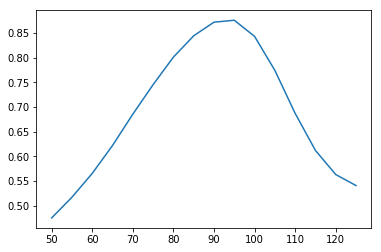

In [8]:
plt.plot(result.keys(), result.values())